# Bayesian calibration of polynomials, including inference of overall normalization

In [1]:
from collections import OrderedDict

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from scipy import stats
from scipy.stats import invgamma, norm

In [4]:
import corner

In [5]:
import rxmc

Using database version X4-2024-12-31 located in: /home/kyle/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [6]:
rng = np.random.default_rng(42)

In [7]:
poly4 = rxmc.physical_model.Polynomial(4)

In [8]:
true_params = [1, 0.5, -0.1, -0.4, 0.1]

In [9]:
settings = [
    {
        "domain": [-0.3, 0.4],
        "N": 50,
        "noise": 0.1,
        "systematic_err": 0.1,
    },
    {
        "domain": [0.3, 0.5],
        "N": 30,
        "noise": 0.1,
        "systematic_err": 0.5,
    },
    {
        "domain": [0.1, 0.6],
        "N": 25,
        "noise": 0.1,
        "systematic_err": 0.2,
    },
    {
        "domain": [-0.5, 0.1],
        "N": 15,
        "noise": 0.2,
        "systematic_err": 0.6,
    },
]

In [10]:
def generate_observations(settings, true_model, rng, true_params, scale_err=True):
    obs = []
    for setting in settings:
        x0, x1 = setting["domain"]
        synthetic_obs = rxmc.observation.Observation(
            x=rng.random(setting["N"]) * (x1 - x0) + x0,
            y=np.zeros(setting["N"]),
            y_stat_err=np.ones(setting["N"]) * setting["noise"],
            y_sys_err_normalization=setting["systematic_err"],
        )
        renormalization = rng.normal(1, setting["systematic_err"])
        y_true = true_model(synthetic_obs, *true_params)
        if scale_err:
            synthetic_obs.y = rng.normal(y_true, setting["noise"]) * renormalization
        else:
            synthetic_obs.y = rng.normal(y_true * renormalization, setting["noise"])

        synthetic_obs.renormalization = renormalization

        obs.append(synthetic_obs)
    return obs

In [11]:
observations = generate_observations(settings, poly4, rng, true_params, scale_err=False)

In [12]:
observations_unreported_sys_err = [
    rxmc.observation.Observation(
        x=obs.x,
        y=obs.y,
        y_stat_err=np.sqrt(np.diag(obs.statistical_covariance)),
    )
    for obs in observations
]

In [13]:
N_fine = 100
domain_fine = (-1, 1)
truth = rxmc.observation.Observation(
    x=np.linspace(*domain_fine, N_fine), y=np.zeros(N_fine)
)
truth.y = poly4(truth, *true_params)

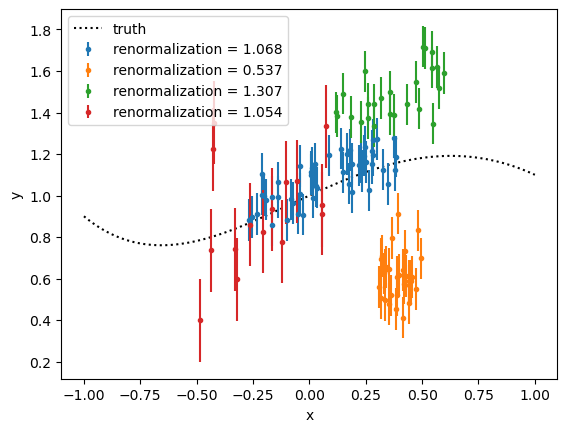

In [14]:
plt.plot(truth.x, truth.y, "k:", label="truth")
for synthetic_observation in observations:
    plt.errorbar(
        synthetic_observation.x,
        synthetic_observation.y,
        np.sqrt(np.diag(synthetic_observation.statistical_covariance)),
        linestyle="none",
        marker=".",
        label=f"renormalization = {synthetic_observation.renormalization:1.3f}",
    )
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [15]:
correct_model = poly4

In [16]:
evidence_models = {}
evidence_models["unknown_norm"] = rxmc.evidence.Evidence(
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [obs],
            correct_model,
            rxmc.likelihood_model.UnknownNormalizationModel(),
        )
        for obs in observations
    ]
)

evidence_models["marginalized_sys_err"] = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            observations,
            correct_model,
            rxmc.likelihood_model.LikelihoodModel(),
        )
    ]
)
evidence_models["unreported_sys_err"] = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            observations_unreported_sys_err,
            correct_model,
            rxmc.likelihood_model.LikelihoodModel(),
        )
    ]
)

evidence_models["unreported_sys_err_with_unknown_model_err"] = rxmc.evidence.Evidence(
    parametric_constraints=[
        rxmc.constraint.Constraint(
            observations_unreported_sys_err,
            correct_model,
            rxmc.likelihood_model.UnknownModelError(),
        )
    ]
)

In [17]:
evidence_models.keys()

dict_keys(['unknown_norm', 'marginalized_sys_err', 'unreported_sys_err', 'unreported_sys_err_with_unknown_model_err'])

In [18]:
print("hyperparameters for each model:")
hyperparams = {}
for key, evidence_model in evidence_models.items():
    hyperparams[key] = []
    for constraint in evidence_model.parametric_constraints:
        for p in constraint.likelihood.params:
            hyperparams[key].append(p)
    print(f"{key}: {[p.name for p in hyperparams[key]]}")

hyperparameters for each model:
unknown_norm: ['log normalization', 'log normalization', 'log normalization', 'log normalization']
marginalized_sys_err: []
unreported_sys_err: []
unreported_sys_err_with_unknown_model_err: ['log fractional err']


## Priors
We will put a tight prior on $a_0$, to avoid identifiability issues, as $a_0$ corresponds to an additive offset of the entire model, which is pretty confounding with a multiplicative bias.

In [19]:
cov = np.diag(np.ones(len(correct_model.params)))
cov[0, 0] = 0.001
model_prior = stats.multivariate_normal(mean=np.array([1, 0, 0, 0, 0]), cov=cov)

In [20]:
unknown_log_norm_priors = [
    stats.multivariate_normal(
        mean=[0], cov=[[np.log(1 + (setting["systematic_err"]) ** 2)]]
    )
    for setting in settings
]

In [21]:
unknown_model_err_prior = stats.multivariate_normal(mean=[np.log(0.1)], cov=[[0.01]])

## Walkers

In [22]:
walkers = {}

In [23]:
walkers["unknown_norm"] = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
        correct_model.params,
        starting_location=model_prior.mean,
        prior=model_prior,
        initial_proposal_cov=model_prior.cov,
    ),
    evidence=evidence_models["unknown_norm"],
    likelihood_samplers=[
        rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
            params=[p],
            starting_location=np.array([0.0]),
            prior=prior,
            initial_proposal_cov=[[prior.cov]],
        )
        for p, prior in zip(hyperparams["unknown_norm"], unknown_log_norm_priors)
    ],
)

In [24]:
walkers["unreported_sys_err_with_unknown_model_err"] = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
        correct_model.params,
        starting_location=model_prior.mean,
        prior=model_prior,
        initial_proposal_cov=model_prior.cov,
    ),
    evidence=evidence_models["unreported_sys_err_with_unknown_model_err"],
    likelihood_samplers=[
        rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
            params=hyperparams["unreported_sys_err_with_unknown_model_err"],
            starting_location=unknown_model_err_prior.mean,
            prior=unknown_model_err_prior,
            initial_proposal_cov=unknown_model_err_prior.cov,
        )
    ],
)

In [25]:
walkers["marginalized_sys_err"] = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
        correct_model.params,
        starting_location=model_prior.mean,
        prior=model_prior,
        initial_proposal_cov=model_prior.cov,
    ),
    evidence=evidence_models["marginalized_sys_err"],
)

In [26]:
walkers["unreported_sys_err"] = rxmc.walker.Walker(
    model_sampler=rxmc.param_sampling.BatchedAdaptiveMetropolisSampler(
        correct_model.params,
        starting_location=model_prior.mean,
        prior=model_prior,
        initial_proposal_cov=model_prior.cov,
    ),
    evidence=evidence_models["unreported_sys_err"],
)

In [27]:
for key, walker in walkers.items():
    print(f"\nRunning {key}")
    walker.walk(n_steps=20000, burnin=8000, batch_size=2000)


Running unknown_norm
Burn-in batch 1/4 completed, 2000 steps.
Burn-in batch 2/4 completed, 2000 steps.
Burn-in batch 3/4 completed, 2000 steps.
Burn-in batch 4/4 completed, 2000 steps.
Batch: 1/10 completed, 2000 steps. 
  Model parameter acceptance fraction: 0.270
  Likelihood parameter acceptance fractions: [0.449, 0.435, 0.452, 0.455]
Batch: 2/10 completed, 2000 steps. 
  Model parameter acceptance fraction: 0.322
  Likelihood parameter acceptance fractions: [0.443, 0.4335, 0.449, 0.4255]
Batch: 3/10 completed, 2000 steps. 
  Model parameter acceptance fraction: 0.289
  Likelihood parameter acceptance fractions: [0.4415, 0.425, 0.4535, 0.4425]
Batch: 4/10 completed, 2000 steps. 
  Model parameter acceptance fraction: 0.276
  Likelihood parameter acceptance fractions: [0.4595, 0.45, 0.4375, 0.451]
Batch: 5/10 completed, 2000 steps. 
  Model parameter acceptance fraction: 0.298
  Likelihood parameter acceptance fractions: [0.45, 0.453, 0.4525, 0.442]
Batch: 6/10 completed, 2000 steps

In [28]:
colors = dict(
    zip(walkers.keys(), ["tab:blue", "tab:orange", "tab:purple", "tab:green"])
)
colors

{'unknown_norm': 'tab:blue',
 'unreported_sys_err_with_unknown_model_err': 'tab:orange',
 'marginalized_sys_err': 'tab:purple',
 'unreported_sys_err': 'tab:green'}

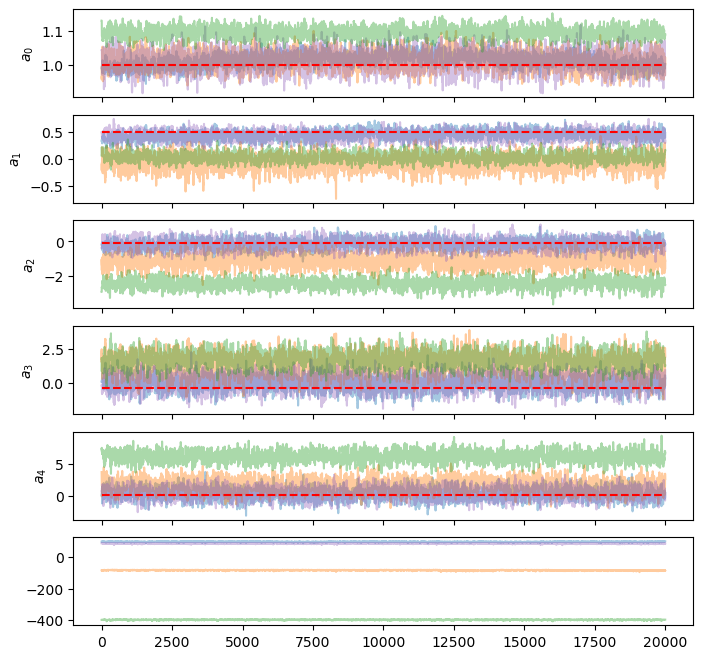

In [29]:
model = correct_model
fig, axes = plt.subplots(
    walkers["marginalized_sys_err"].model_sampler.chain.shape[1] + 1,
    1,
    figsize=(8, 8),
    sharex=True,
)
for i in range(walker.model_sampler.chain.shape[1]):
    # plot walkers
    for key, walker in walkers.items():
        axes[i].plot(walker.model_sampler.chain[:, i], alpha=0.4, color=colors[key])

    axes[i].set_ylabel(f"${model.params[i].latex_name}$")
    true_value = true_params[i]
    axes[i].hlines(true_value, 0, len(walker.model_sampler.chain), "r", linestyle="--")

# plot likelihoods
for key, walker in walkers.items():
    axes[-1].plot(walker.model_sampler.logp_chain, alpha=0.4, color=colors[key])

In [30]:
prior_samples = model_prior.rvs(walker.model_sampler.chain.shape[0])
prior_samples.shape

(20000, 5)

In [31]:
domain = np.zeros((len(walkers), correct_model.n_params, 2))
for i, (key, walker) in enumerate(walkers.items()):
    domain[i, ...] = np.array(
        [
            np.min(walker.model_sampler.chain, axis=0),
            np.max(walker.model_sampler.chain, axis=0),
        ]
    ).T
domain = np.array([np.min(domain[:, :, 0], axis=0), np.max(domain[..., 1], axis=0)])

In [32]:
domain.shape

(2, 5)

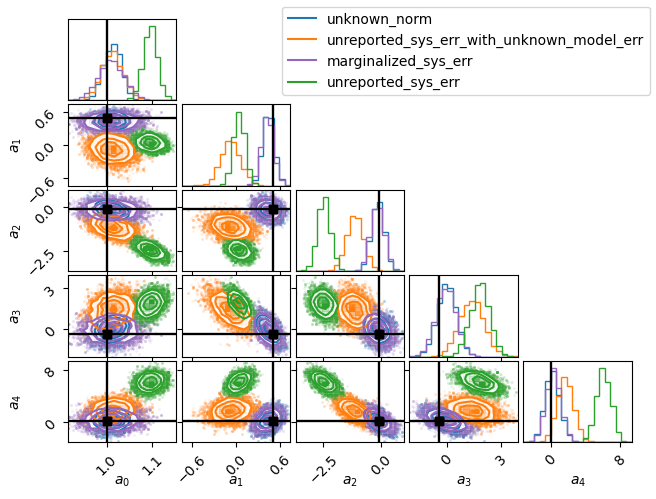

In [33]:
fig = plt.figure()
for key, walker in walkers.items():
    corner.corner(
        walker.model_sampler.chain,
        fig=fig,
        color=colors[key],
        range=domain.T,
        labels=[f"${p.latex_name}$" for p in correct_model.params],
        truths=true_params,
        labelpad=0.1,
        max_n_ticks=2,
        truth_color="k",
    )

    plt.plot([], [], color=colors[key], label=key)
fig.legend()
# plt.tight_layout()

As expected, `unknown_norm` and `marginalized_sys_err` are the same. This is because they originate from the same exact statistical model, in which the normalization of each data set is a random variable. The latter explicitly marginalizes over the renormalization according to $\mathcal{N}(1,\sigma_{sys})$, whereas the former takes that distribution as a prior but attempts to learn the real distribution by conditioning the data. 

In this case the underlying process for generating $N$ is exactly what the experimentalists report (that is, it is $\mathcal{N}(1,\sigma_{sys})$). If the experimentally reported $\sigma_{sys}$ was incorrect, then `marginalized_sys_err` would not be marginalizing over the correct distribution, and would converge to something wrong (try it!). On the other hand, with `unknown_norm`, incorrect experimentally reported $\sigma_{sys}$ just means a bad prior: $\sigma_{sys}$ doesn't enter into the likelihood at all. Eventually, sampling should converge to the appropriate distribution.

Of course, the other two methods, which do not account for systematic error at all, fail to converge to the region of the truth.

## Let's explore the performance of the inference of the normalizations from the "unknown norm" model

We will look at the posteriors of $\rho_i$, the renormalization of the model predictions with respect to each data set. We will look at the *maxima a posteriori* (MAP) and compare them to the values we actually renormalized by when generating the synthetic data. Then we will plot the experimental values renormalized by the MAP $\rho$s, and we should see that they re-align themselves with the truth.

In [51]:
norm_chain = np.array(
    [sampler.chain for sampler in walkers["unknown_norm"].likelihood_samplers]
)[:, :, 0]
norm_chain = np.exp(norm_chain.T)
norm_chain.shape

(20000, 4)

In [52]:
norm_log_posterior_vals = np.array(
    [sampler.logp_chain for sampler in walkers["unknown_norm"].likelihood_samplers]
).T
norm_log_posterior_vals.shape

(20000, 4)

In [60]:
map_idxs = np.argmax(norm_log_posterior_vals, axis=0)
N_data_sets = len(settings)
maps = norm_chain[map_idxs, np.arange(N_data_sets)]
maps

array([1.02222029, 0.5391869 , 1.26555557, 1.03850914])

In [61]:
np.array([obs.renormalization for obs in observations])

array([1.06789136, 0.53671203, 1.3071512 , 1.05429387])

In [37]:
np.mean(norm_chain, axis=0)

array([1.04122028, 0.52298738, 1.27509224, 1.00875858])

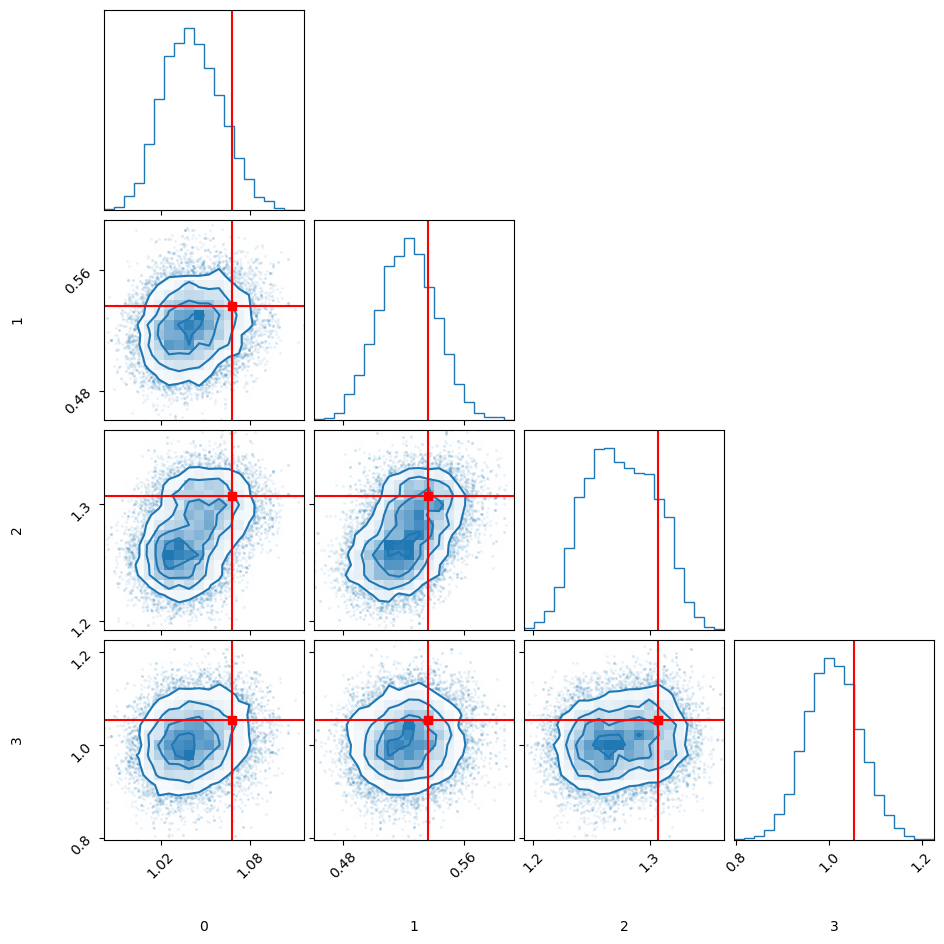

In [38]:
fig = corner.corner(
    norm_chain,
    labels=range(len(settings)),
    truths=[obs.renormalization for obs in observations],
    labelpad=0.1,
    max_n_ticks=2,
    color="tab:blue",
    truth_color="red",
)

Text(0.5, 1.0, 'Renormalizing experimental data sets based on MAP of $p(\\rho)$')

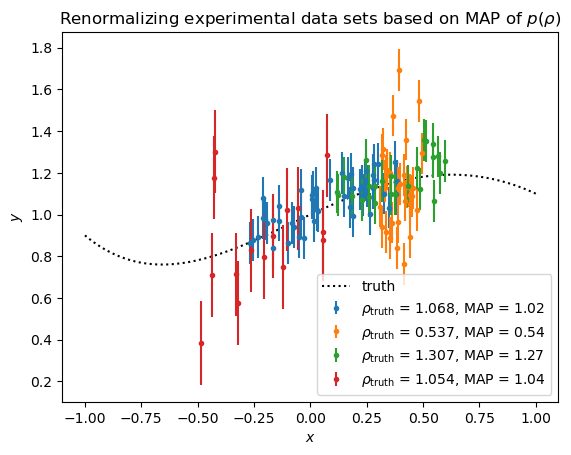

In [62]:
plt.plot(truth.x, truth.y, "k:", label="truth")
for i, synthetic_observation in enumerate(observations):
    rho_hat = maps[i]
    plt.errorbar(
        synthetic_observation.x,
        synthetic_observation.y / rho_hat,
        np.sqrt(np.diag(synthetic_observation.statistical_covariance)),
        linestyle="none",
        marker=".",
        label=r"$\rho_{\text{truth}}$ = "
        + f"{synthetic_observation.renormalization:1.3f},"
        + r" MAP = "
        + f"{rho_hat:1.2f}",
    )
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.title(r"Renormalizing experimental data sets based on MAP of $p(\rho)$")

## predictive posteriors

In [40]:
walker.model_sampler.chain.shape

(20000, 5)

In [41]:
def predictive_post(chain, model, obs, n_samples, intervals):
    draw_idxs = rng.choice(np.arange(chain.shape[0]), n_samples)
    draws = chain[draw_idxs, :]
    observations = []
    credible_intervals = []
    ym = np.array([model(obs, *p) for p in draws])
    return np.percentile(ym, intervals, axis=0)

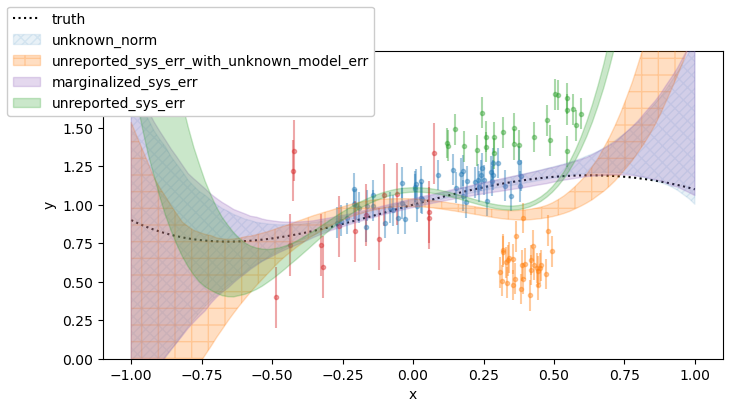

In [46]:
fig = plt.figure(figsize=(8, 4))
plt.plot(truth.x, truth.y, "k:", label="truth")

for synthetic_observation in observations:
    plt.errorbar(
        synthetic_observation.x,
        synthetic_observation.y,
        np.sqrt(np.diag(synthetic_observation.statistical_covariance)),
        linestyle="none",
        marker=".",
        alpha=0.4,
        # label=f"renormalization = {synthetic_observation.renormalization:1.3f}",
    )

hatches = ["//\\//\\", "|-", "", ""]
alphas = [0.1, 0.25, 0.25, 0.25]
for i, (key, walker) in enumerate(walkers.items()):
    intervals = predictive_post(
        walker.model_sampler.chain,
        correct_model,
        truth,
        1000,
        [16, 84],
    )
    plt.fill_between(
        truth.x,
        intervals[0],
        intervals[1],
        alpha=alphas[i],
        color=colors[key],
        label=key,
        hatch=hatches[i],
        zorder=99,
    )
plt.xlabel("x")
plt.ylabel("y")
plt.ylim([0,2])
fig.legend(loc="upper left", framealpha=1)